In [1]:
import gymnasium as gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self, seed=None):
        state, info = self.env.reset()
        self.step_n = 0
        return state, info

    def step(self, action):
        state, reward, done, truncated, info = self.env.step(action)

        #一局游戏最多走N步
        self.step_n += 1
        if self.step_n >= 200:
            done = True

        return state, reward, done, truncated, info

env = MyWrapper()

env.reset()

(array([-0.9938945 ,  0.1103342 ,  0.82647383], dtype=float32), {})

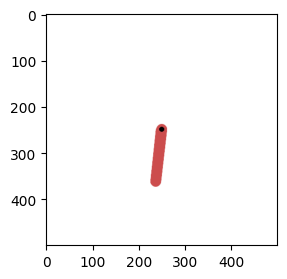

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.figure(figsize=(3, 3))
    plt.imshow(env.render())
    plt.show()


show()

In [3]:
#认识游戏环境
def test_env():
    print('env.observation_space=', env.observation_space)
    print('env.action_space=', env.action_space)

    state, _ = env.reset()
    action = env.action_space.sample()
    next_state, reward, done, _, _ = env.step(action)

    print('state=', state)
    print('action=', action)
    print('next_state=', next_state)
    print('reward=', reward)
    print('done=', done)


test_env()

env.observation_space= Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
env.action_space= Box(-2.0, 2.0, (1,), float32)
state= [ 0.83780456 -0.5459703  -0.0055849 ]
action= [-0.7061217]
next_state= [ 0.8232999 -0.5676066 -0.5209809]
reward= -0.33406206346250517
done= False


In [4]:
import torch

#计算动作的模型,也是真正要用的模型
model = torch.nn.Sequential(
    torch.nn.Linear(3, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 11),
)

#经验网络,用于评估一个状态的分数
next_model = torch.nn.Sequential(
    torch.nn.Linear(3, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 11),
)

#把model的参数复制给next_model
next_model.load_state_dict(model.state_dict())

model, next_model

(Sequential(
   (0): Linear(in_features=3, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=11, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=3, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=11, bias=True)
 ))

In [5]:
import random


def get_action(state):
    #走神经网络,得到一个动作
    state = torch.FloatTensor(state).reshape(1, 3)
    action = model(state).argmax().item()

    if random.random() < 0.01:
        action = random.choice(range(11))

    #离散动作连续化
    action_continuous = action
    action_continuous /= 10
    action_continuous *= 4
    action_continuous -= 2

    return action, action_continuous


get_action([0.29292667, 0.9561349, 1.0957013])

(10, 2.0)

In [6]:
#样本池
datas = []


#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    old_count = len(datas)

    #玩到新增了N个数据为止
    while len(datas) - old_count < 200:
        #初始化游戏
        state, _ = env.reset()

        #玩到游戏结束为止
        over = False
        while not over:
            #根据当前状态得到一个动作
            action, action_continuous = get_action(state)

            #执行动作,得到反馈
            next_state, reward, over, _, _ = env.step([action_continuous])

            #记录数据样本
            datas.append((state, action, reward, next_state, over))

            #更新游戏状态,开始下一个动作
            state = next_state

    #数据上限,超出时从最古老的开始删除
    while len(datas) > 5000:
        datas.pop(0)


update_data()

len(datas)

200

In [7]:
#获取一批数据样本
def get_sample():
    #从样本池中采样
    samples = random.sample(datas, 64)

    #[b, 3]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)
    #[b, 1]
    action = torch.LongTensor([i[1] for i in samples]).reshape(-1, 1)
    #[b, 1]
    reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
    #[b, 3]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3)
    #[b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state, action, reward, next_state, over

/tmp/ipykernel_188197/1416897299.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)


(tensor([[-0.9930, -0.1183, -2.5628],
         [-0.4304, -0.9026,  0.8721],
         [-0.8763,  0.4818, -3.2048],
         [-0.4255,  0.9050, -3.9083],
         [-0.4870,  0.8734,  3.6312],
         [-0.4324,  0.9017, -4.6307],
         [-0.1962,  0.9806, -1.9116],
         [-0.8368, -0.5476, -3.5788],
         [-0.9118,  0.4107,  3.7801],
         [-0.6377, -0.7703,  3.1029],
         [-0.4825,  0.8759,  2.0366],
         [-0.9830,  0.1835, -5.6264],
         [-0.8237, -0.5670, -4.1427],
         [-0.5931,  0.8051, -4.2722],
         [-0.9749, -0.2227,  0.6293],
         [-0.9976,  0.0686,  4.5893],
         [-0.9352, -0.3542,  0.3227],
         [-0.9798,  0.2000,  1.5365],
         [-0.8009,  0.5988, -5.3916],
         [-0.7632, -0.6462, -2.1214],
         [-0.9299,  0.3679,  4.9293],
         [-0.6003,  0.7998,  3.3722],
         [-0.9700, -0.2431,  3.2817],
         [-0.8980, -0.4401,  0.3652],
         [-0.8683, -0.4961,  3.2847],
         [-0.2203,  0.9754,  1.2052],
         [-0

In [8]:
def get_value(state, action):
    #使用状态计算出动作的logits
    #[b, 3] -> [b, 11]
    value = model(state)

    #根据实际使用的action取出每一个值
    #这个值就是模型评估的在该状态下,执行动作的分数
    #在执行动作前,显然并不知道会得到的反馈和next_state
    #所以这里不能也不需要考虑next_state和reward
    #[b, 11] -> [b, 1]
    value = value.gather(dim=1, index=action)

    return value


get_value(state, action)

tensor([[0.5668],
        [0.4912],
        [0.5240],
        [0.5130],
        [1.4597],
        [0.5870],
        [0.3926],
        [0.7402],
        [1.5257],
        [1.3812],
        [0.7824],
        [0.8506],
        [0.8050],
        [0.5510],
        [0.2490],
        [1.8945],
        [0.2020],
        [0.5561],
        [0.7246],
        [0.5707],
        [2.0261],
        [1.3448],
        [1.3452],
        [0.1968],
        [1.3856],
        [0.5139],
        [0.3532],
        [0.3756],
        [0.5267],
        [0.7894],
        [0.3820],
        [0.4604],
        [0.2566],
        [0.5587],
        [0.4744],
        [1.7215],
        [0.7990],
        [1.6567],
        [0.3605],
        [0.4122],
        [1.4125],
        [0.1995],
        [1.0017],
        [1.3850],
        [0.7258],
        [0.5127],
        [1.2073],
        [0.3812],
        [1.3444],
        [0.4497],
        [0.1836],
        [1.2017],
        [0.4013],
        [0.3846],
        [0.4628],
        [2

In [9]:
def get_target(reward, next_state, over):
    #上面已经把模型认为的状态下执行动作的分数给评估出来了
    #下面使用next_state和reward计算真实的分数
    #针对一个状态,它到底应该多少分,可以使用以往模型积累的经验评估
    #这也是没办法的办法,因为显然没有精确解,这里使用延迟更新的next_model评估

    #使用next_state计算下一个状态的分数
    #[b, 3] -> [b, 11]
    with torch.no_grad():
        target = next_model(next_state)

    #取所有动作中分数最大的
    #[b, 11] -> [b, 1]
    target = target.max(dim=1)[0]
    target = target.reshape(-1, 1)

    #下一个状态的分数乘以一个系数,相当于权重
    target *= 0.98

    #如果next_state已经游戏结束,则next_state的分数是0
    #因为如果下一步已经游戏结束,显然不需要再继续玩下去,也就不需要考虑next_state了.
    #[b, 1] * [b, 1] -> [b, 1]
    target *= (1 - over)

    #加上reward就是最终的分数
    #[b, 1] + [b, 1] -> [b, 1]
    target += reward

    return target


get_target(reward, next_state, over)

tensor([[ -9.2254],
        [ -3.9043],
        [ -7.5286],
        [ -5.1630],
        [ -3.9848],
        [ -5.7393],
        [ -3.1193],
        [ -7.0706],
        [ -7.2352],
        [ -4.9941],
        [ -3.7365],
        [-11.1322],
        [ -7.3278],
        [ -6.1902],
        [ -8.3087],
        [ -9.7052],
        [ -7.5411],
        [ -8.3224],
        [ -8.5206],
        [ -5.7618],
        [ -8.0110],
        [ -4.5211],
        [ -8.2545],
        [ -7.0424],
        [ -6.7793],
        [ -2.5121],
        [ -7.0295],
        [ -8.8177],
        [ -6.2107],
        [ -9.9031],
        [ -3.5228],
        [ -3.8068],
        [ -3.7281],
        [ -8.3590],
        [ -6.7211],
        [ -6.8511],
        [ -4.6086],
        [ -6.7122],
        [ -3.1481],
        [ -5.6131],
        [ -9.2460],
        [ -7.6293],
        [ -4.3329],
        [ -6.1065],
        [ -9.7337],
        [ -4.3398],
        [ -5.1291],
        [ -2.0326],
        [ -4.0850],
        [ -7.5372],


In [10]:
from IPython import display


def test(play=False):
    state, _ = env.reset()
    reward_sum = 0
    over = False
    while not over:
        _, action_continuous = get_action(state)
        state, reward, over, _, _ = env.step([action_continuous])
        reward_sum += reward

        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


sum([test() for _ in range(20)]) / 20

-1327.6399255146657

In [11]:
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_fn = torch.nn.MSELoss()

    #训练N次
    for epoch in range(200):
        #更新N条数据
        update_data()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = get_sample()

            #计算一批样本的value和target
            value = get_value(state, action)
            target = get_target(reward, next_state, over)

            #更新参数
            loss = loss_fn(value, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #把model的参数复制给next_model
            if (i + 1) % 50 == 0:
                next_model.load_state_dict(model.state_dict())

        if epoch % 20 == 0:
            print(epoch, len(datas), sum([test() for _ in range(5)]) / 5)

    torch.save(model, 'save/5.DQN_Pendulum')


train()

0 400 -900.7409038281482
20 4400 -1007.3344208102037
40 5000 -1028.5418135658251
60 5000 -983.9537874831731
80 5000 -719.2350625756867
100 5000 -274.31433706348855
120 5000 -120.46754486272698
140 5000 -223.56352107071316
160 5000 -148.11827508670407
180 5000 -188.69744420024398


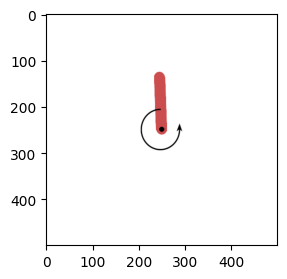

-1.9961218689708229

In [12]:
model = torch.load('save/5.DQN_Pendulum')

test(play=True)